$\textbf{Aim:}$ 

Using data from http://archive.ics.uci.edu/ml/datasets/Wine,

We want to predict the quality of red wine given the characteristics used to make the wine.



$\textbf{Steps:}$

* Get the data and analyse it
 * Visualise the data,  select the targets and the features to train our models on
* Preprocess the data
* Split the dataset into training and test sets
* Build models and fit them on the training data
* Evaluate the models and select the winning model
* Evaluate the winning model and fiddle with its hyperparameters to get the best model for our dataset
* Evaluate the features (feature importance) and see if we should drop any of them
* Retrain the resulting model
* Try finding a better model using a genetic algorithm (TPOT)

We Begin by importing the relevant libraries

In [0]:
import numpy as np  # For array manipulation
import pandas as pd # For dataframes

# for model selection
from sklearn.model_selection import train_test_split, GridSearchCV 

# The sklearn library for preprocessing our data
from sklearn import preprocessing

# The models we will be using
from sklearn.ensemble import RandomForestClassifier #, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
!pip install tpot
from tpot import TPOTClassifier

# For making the data processing pipelines
from sklearn.pipeline import Pipeline, make_pipeline

# metrics for evaluating model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score


# To save our model for future use
from sklearn.externals import joblib # like pickle but more efficient for larger np arrays

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 153kB 14.0MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=b99e0aaf8b18117f02bb8f6eb75c8551736a40ad3c59a9ec6df78e8439dfdbe2
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### The data we'll be using

In [0]:
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Our task is to predict wine quality using the following attributes: 
'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates' and 'alcohol'

## Exploratory Data Analysis

In [0]:
target = data.quality # The targets column 
X = data.drop('quality', axis=1) # features

print('\nOur data has %d observations and %d features\n' %(X.shape[0], X.shape[1]))

#columns with missing data
print('Are there missing observations the columns?\n', (data.isnull().any()))

print('\nThere are', target.nunique(), 'Unique values for quality, namely:', sorted(target.unique())) 



Our data has 1599 observations and 11 features

Are there missing observations the columns?
 fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

There are 6 Unique values for quality, namely: [3, 4, 5, 6, 7, 8]


### Let's visualise our data: 

How many wines of each quality are in the dataset?

In [0]:
vgq = data[target>6]  #top tier quality
aq = data[(target>=5) & (target<=6)]  #average quality
bq = data[target<5]   #bad quality

print('%.2f %% of the wines are of top tier quality' %(100*len(vgq)/len(target)))
print('%.2f %% of the wines are of average quality' %(100*len(aq)/len(target)))
print('%.2f %% of the wines are below average quality' %(100*len(bq)/len(target)))

13.57 % of the wines are of top tier quality
82.49 % of the wines are of average quality
3.94 % of the wines are below average quality


What does the wine quality distribution look like in a ~histogram~ bar graph?

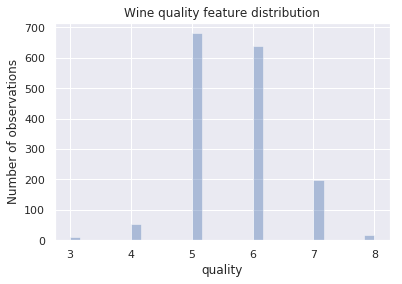

In [0]:
sns.distplot(target, norm_hist=False, kde=False)
plt.title('Wine quality feature distribution')
plt.ylabel('Number of observations')
plt.show()

Most wines are of average quality, less than half are above average while even fewer are below average

We are interested in the excellent quality wines

Let's separate the wines of excellent quality ($\geq 7$) from the rest of the wines. 
We will be building classifiers for the excelent quality wine only.

Let's begin by creating a column of binary values in the features dataframe X, which indicates whether the wine is of excellent (1) or less than excellent quality (0):


In [0]:
XX = X.copy() # To be safe, let's only modify a copy of the features DF

XX['best_quality'] = 1
XX['best_quality'][target<7] = 0 # All wines less than excellent

XX.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,best_quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.135710
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.342587
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


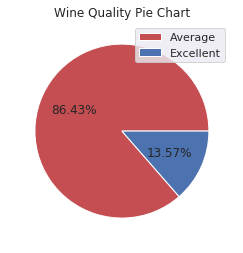

In [0]:
plt.pie(XX.best_quality.value_counts(), autopct='%1.2f%%', colors=['r', 'b'])
plt.legend(labels=['Average', 'Excellent'], loc='best')
plt.title('Wine Quality Pie Chart')
plt.show()

Our problem is thus:

Given the features in $\texttt{XX.columns.values}$, we want to predict whether or not a wine will be of excellent quality

In [0]:
# The targets are now composed of 2 classes (excellent and not excellent)
y = XX.best_quality 
# Let's drop the targets column from the features dataframe
XX = XX.drop(['best_quality'], axis=1) 

Before we proceed to the next step, Let's have a look at the correlations between our features

The features we train our data on should not be too correlated with each other, to avoid [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity), an assumption in Linear Regression analysis which could also be an issue [in Classification problems](https://stats.stackexchange.com/questions/266267/should-one-be-concerned-about-multi-collinearity-when-using-non-linear-models/352760)

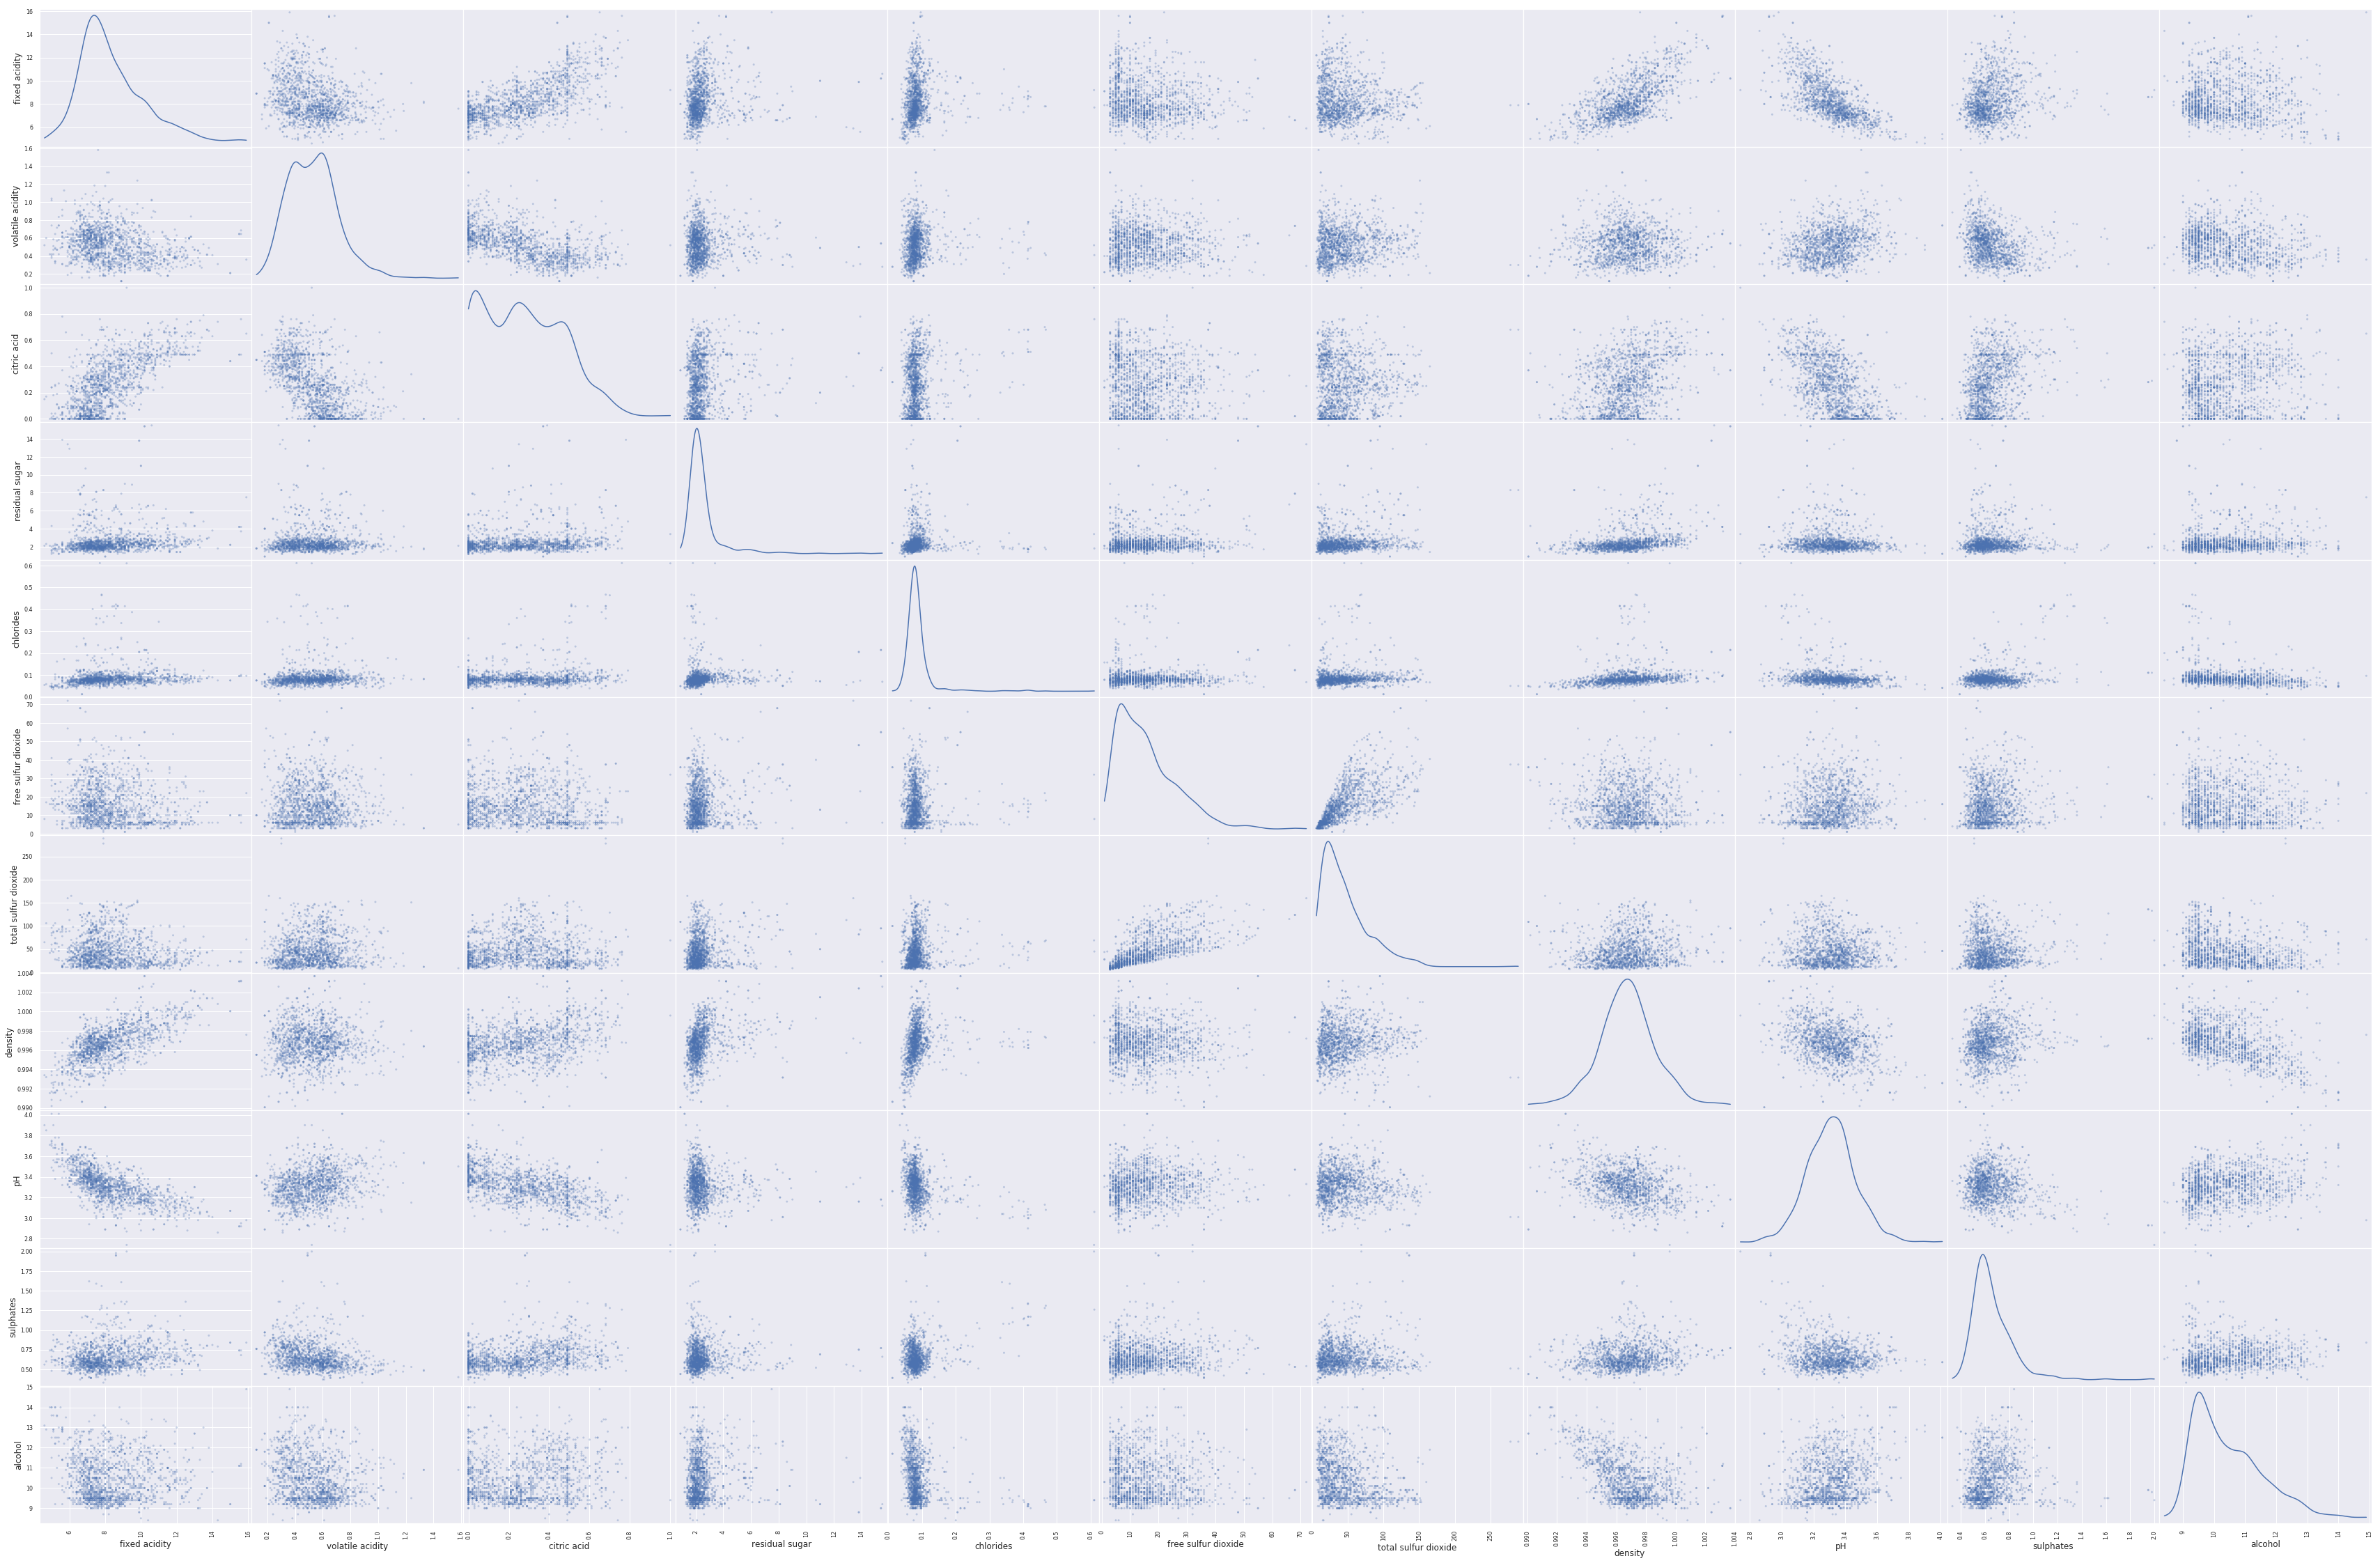

In [0]:
pd.plotting.scatter_matrix(XX, alpha = 0.3, figsize = (60,40), diagonal = 'kde');


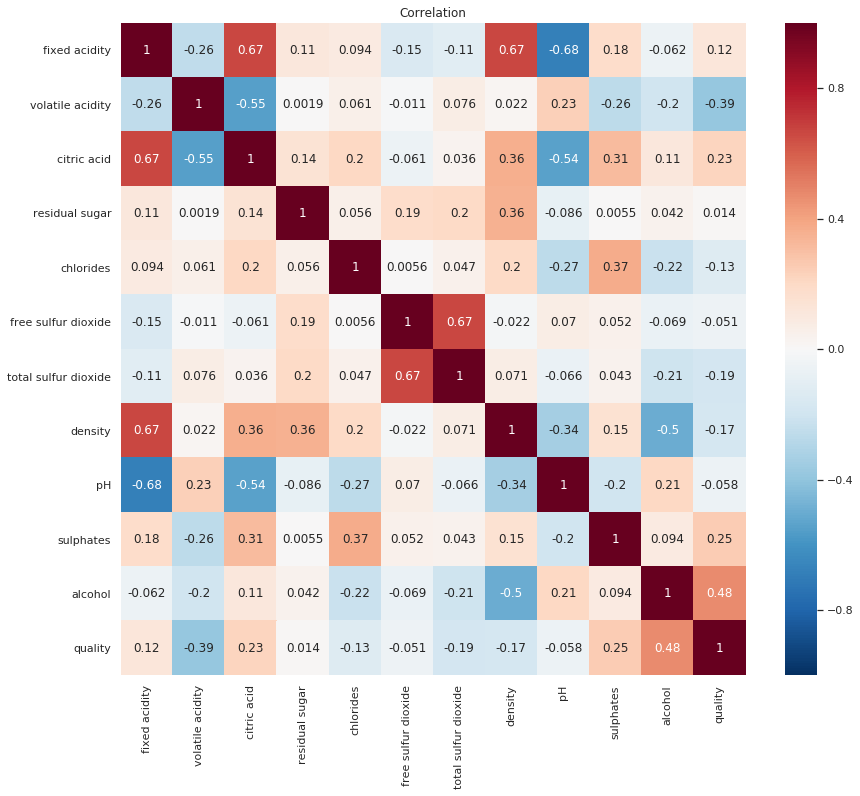

In [0]:
correlation = data.corr()
plt.figure(figsize=(14,12))
plt.title('Correlation')
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
plt.show()

There is no consensus on what the correlation threshold for multicollinearity is, and thus might be down to trial and error.

We will first train our models with all the features and later check if we can increase model accuracy by addressing the highest correlations

# Preprocessing

We start by splitting the data into training and test sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.25,
                                                   random_state=0, stratify=y)

# Do we have any categorical variables in our features?
cat = [cname for cname in XX.columns if XX[cname].dtype=='object']
print('There are %d columns with categorical entries\n' %len(cat))



There are 0 columns with categorical entries



All the features are conveniently **numerical**.
However, since they have different scales, we should standardize them.

Thus preprocessing in this case solely entails standardization, which we will perform in pipelines

# Models

We will try multiple ML classifier algorithms and evaluate their performance to select the best model for our problem. 

We will try training the following algorithms on our data:

A Decision Tree Classifier

A Random Forest ensemble Classifier

and the eXtreme Gradient Boosting Classifier

In [0]:
print('Defining the Classifiers and fitting them on our training data...')

decTree_pipeline = Pipeline(steps=[('preprocessor', preprocessing.StandardScaler()), 
                                   ('model', DecisionTreeClassifier(random_state=0))])
decTree_pipeline.fit(X_train, y_train)

RF = Pipeline(steps=[('preprocessor', preprocessing.StandardScaler()),
                     ('model', RandomForestClassifier(n_estimators=1000, random_state=0))])
RF.fit(X_train, y_train)


xgb = Pipeline(steps=[('preprocessor', preprocessing.StandardScaler()), 
              ('model', xgboost.XGBClassifier(n_estimators=1000, learning_rate=0.05))])
xgb.fit(X_train, y_train)

print('...\nDone!')

Defining the Classifiers and fitting them on our training data...
...
Done!


## Model predictions

In [0]:
tree_pred = decTree_pipeline.predict(X_test) #decision tree
rf_pred = RF.predict(X_test)
xgb_pred = xgb.predict(X_test)

### Evaluating Classifier Performance

#### Classification Accuracy: 
What percentage of the predictions made by each model were correct?

In [0]:
print ('Accuracy: Decision Tree = %s%%' %(100*accuracy_score(y_test, tree_pred)))
print ('Accuracy: Random Forest = %s%%' %(100*accuracy_score(y_test, rf_pred)))
print ('Accuracy: xg boost = %s%%' %(100*accuracy_score(y_test, xgb_pred)))

Accuracy: Decision Tree = 89.25%
Accuracy: Random Forest = 90.25%
Accuracy: xg boost = 91.0%


##### Null Accuracy:
The accuracy we would get if the classifier always predicted the most common class (0 in this case)

In [0]:
print('A model that always predicts insipid wine quality would be\
 accurate\n %.2f%% of the time' %(100*(1-y_test.mean())))

A model that always predicts insipid wine quality would be accurate
 86.50% of the time


This is because only $\sim 13.57$ % of the observations (wines considered) are of excellent quality.

Let's see what insights we can get from other classification performance measures 

### The Confusion Matrix
describes a classification model's performance by comparing the predicted classes to the expected classes

The rows represent the actual (True) classes while the columns represent the predicted classes

In [0]:
print('Confusion Matrix for simple, gradient boosted, and random forest tree classifiers:')
print('Simple Tree:\n',confusion_matrix(y_test,tree_pred),'\n')
print('Gradient Boosted:\n',confusion_matrix(y_test,rf_pred),'\n')
print('Random Forest:\n',confusion_matrix(y_test, xgb_pred))

Confusion Matrix for simple, gradient boosted, and random forest tree classifiers:
Simple Tree:
 [[324  22]
 [ 21  33]] 

Gradient Boosted:
 [[331  15]
 [ 24  30]] 

Random Forest:
 [[327  19]
 [ 17  37]]


We could display these confusion matrices much better (as heatmaps) with seaborn

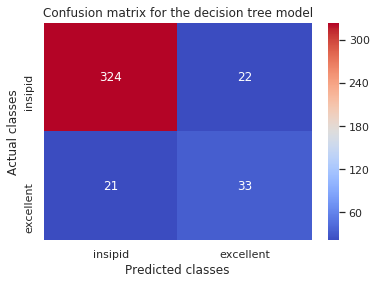

In [0]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, tree_pred), annot=True, fmt='d', cmap='coolwarm')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')
ax.xaxis.set_ticklabels(['insipid', 'excellent'])
ax.yaxis.set_ticklabels(['insipid', 'excellent'])
plt.title('Confusion matrix for the decision tree model')
plt.show()

In [0]:
tot = 324+22+33+21
tot

400

The decision tree model classifies 

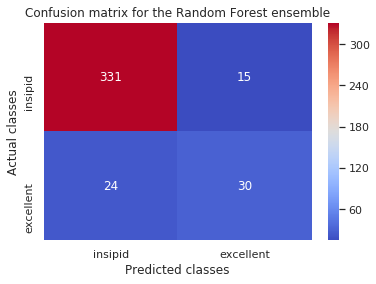

In [0]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='coolwarm')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')
ax.xaxis.set_ticklabels(['insipid', 'excellent'])
ax.yaxis.set_ticklabels(['insipid', 'excellent'])
plt.title('Confusion matrix for the Random Forest ensemble')
plt.show()

In [0]:
coco = ['lolo', 'popo', 'dodo']
list(enumerate(coco, 2019))

[(2019, 'lolo'), (2020, 'popo'), (2021, 'dodo')]

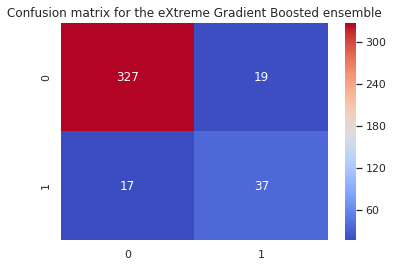

In [0]:
coolwarmax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='coolwarm')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')
ax.xaxis.set_ticklabels(['insipid', 'excellent'])
ax.yaxis.set_ticklabels(['insipid', 'excellent'])
plt.title('Confusion matrix for the eXtreme Gradient Boosted ensemble')
plt.show()

Each model's performance is summarized in the Classification report below:

In [0]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       346
           1       0.60      0.61      0.61        54

    accuracy                           0.89       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.89      0.89      0.89       400



In [0]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       346
           1       0.67      0.56      0.61        54

    accuracy                           0.90       400
   macro avg       0.80      0.76      0.78       400
weighted avg       0.90      0.90      0.90       400



In [0]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       346
           1       0.66      0.69      0.67        54

    accuracy                           0.91       400
   macro avg       0.81      0.82      0.81       400
weighted avg       0.91      0.91      0.91       400



Finally, let's use the ROC curve to find the balance between **sensitivity** and specificity 

In [0]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       346
           1       0.60      0.61      0.61        54

    accuracy                           0.89       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.89      0.89      0.89       400



We use the probabilistic predictions instead of the regular predictions 
here.

In [0]:
tree_pred_prob = decTree_pipeline.predict_proba(X_test)[:,1]
rf_pred_prob = RF.predict_proba(X_test)[:,1]
xgb_pred_prob = xgb.predict_proba(X_test)[:,1]

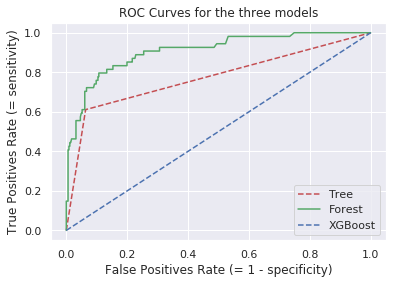

In [0]:
fp_tree, tp_tree, thresh_tree = roc_curve(y_test, tree_pred_prob)
fp_rf, tp_rf, thresh_rf = roc_curve(y_test, rf_pred_prob)
fp_xgb, tp_xgb, thresh_xgb = roc_curve(y_test, xgb_pred_prob)

plt.plot(fp_tree, tp_tree, 'r--', label='Tree')
plt.plot(fp_rf, tp_rf, 'g-', label='Forest')
plt.plot(fp_xgb, fp_xgb, 'b--', label='XGBoost')
plt.title('ROC Curves for the three models')
plt.xlabel('False Positives Rate (= 1 - specificity)')
plt.ylabel('True Positives Rate (= sensitivity)')
plt.legend(loc='best')
plt.show()

Area Under the Curve for each of the classifiers:


In [0]:
print('Decision Tree AUC:\t %.2f%%' %(100*roc_auc_score(y_test, tree_pred_prob)))

print('Random Forest AUC:\t %.2f%%'  %(100*roc_auc_score(y_test, rf_pred_prob)))

print('XGBoosting AUC: \t %.2f' %(100*roc_auc_score(y_test, xgb_pred_prob)))

Decision Tree AUC:	 77.38%
Random Forest AUC:	 90.80%
XGBoosting AUC: 	 90.21


The random forest is the clear winner here!

We must thus optimize the RF

But first, let's see if TPOT can't do much better

In [0]:
!pip install tpot

In [0]:
from tpot import TPOTClassifier

In [0]:
tpot =  TPOTClassifier(generations=10, population_size=20, verbosity=3, n_jobs=-1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

30 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 '(slice(None, None, None), 0)' is an invalid key.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
Generation 1 - Current Pareto front scores:
-1	0.8898981319120125	LogisticRegression(input_matrix, LogisticRegression__C=20.0, LogisticRegression__dual=False, LogisticRegression__penalty=l2)
-2	0.9032559593048491	BernoulliNB(RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=False, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.6500000000000001, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=100), BernoulliNB__alpha=1.0, BernoulliNB__fit_prior=False)

_pre_test decorator: _random_mutation_operator: num_test=0 feature_names mismatch: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides

In [0]:
tpot.export('tpot_wine_pipeline.py')

!cat tpot_wine_pipeline.py

import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.9107525014901879
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=MultinomialNB(alpha=0.1, fit_prior=False)),
    FastICA(tol=0.5),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=8, max_features=0.4, min_samples_leaf=1, 

In [0]:
#tpot.evaluated_individuals_

#tpot.evaluated_pipeline_

In [0]:
accuracy_score(y_test, tpot.predict(X_test)), accuracy_score(y_test, RF.predict(X_test))

(0.8875, 0.9025)

In [0]:
1-(0.9025/0.9075)

0.005509641873278293

## Feature Importances:

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 5.1MB/s 


In [0]:
import eli5 
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [0]:
perm = PermutationImportance(xgrad, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

NameError: ignored